In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# interest rate for Net Present Value calculations
rate = 4/100; # 4.0#
# data for generator dispatch problem
D = 365; # days in a year
Y = 20; # years simulated
T = 24; # hours simulated in each day
t= np.arange(T); # vector of time
d = 40 * np.array([
    0.4, 0.4, 0.4, 0.65,
    0.65, 0.6, 0.6, 0.65,
    0.8, 0.85, 0.8, 0.8,
    0.75, 0.6, 0.5, 0.3, 
    0.3, 0.4, 0.54, 0.6, 
    0.75, 0.7, 0.6, 0.5
]) # daily demand in MWh
n = 4; # number of dispatchable generators (2 hard coal and 2 OCGT plants) to choose from,
# in addition to a solar plant
solar_cap_fact = np.concatenate((
    np.zeros(6),
    np.sin(np.pi*np.arange(0, 13)/12),
    np.zeros(24-6-(np.arange(0,13).size))
))
# capacity factor of the potential solar plant = power_available/installed_capacity
# (To be used in Part II only: capacity factor of the potential wind plant = power_available/installed_capacity)
wind_cap_fact = np.array([
    0.3277, 0.2865, 0.3303, 0.3073, 0.2994, 0.3071,
    0.2980, 0.2988, 0.3149, 0.3141, 0.3142, 0.5*0.3067, 
    0.5*0.2879, 0.5*0.3072, 0.5*0.3163, 0.5*0.3049, 0.5*0.3103, 
    0.3914, 0.4008 , 0.3879, 0.3889, 0.3999, 0.4153, 0.3923
])
Pmax = np.array([10, 5, 10, 15]) 
# Maximum generator capacities in MW [hard coal, hard coal, OCGT, OCGT] due to land constraints
Pmax_solar = 40; # Maximum capacity in MW for solar plant due to land constraints
Pmin = np.zeros(4) # generator minimum capacities in MW
Pmin_solar = 0;
ramp_hard_coal = 0.015 # 1.5# [# Pnom/minute]
hourly_ramp_hard_coal = ramp_hard_coal*60; # [# Pnom/h]
ramp_ocgt = 0.08 # 1.5# [# Pnom/min]
hourly_ramp_ocgt = ramp_ocgt*60; # [# Pnom/h]
R = np.array([hourly_ramp_hard_coal, hourly_ramp_hard_coal, hourly_ramp_ocgt, hourly_ramp_ocgt]) * Pmax 
# [hourly_ramp_hard_coal*Pmax[0], hourly_ramp_hard_coal*Pmax[1], hourly_ramp_ocgt*Pmax[2], hourly_ramp_ocgt*Pmax[3]]; # ramp-rate limits [MWh]
# source:
# https://www.eia.gov/electricity/annual/html/epa_08_04.html
#
fuel_cost_per_MWh_2018 = np.array([25.4, 25.4, 27.35, 27.35]); # $/MWh, 2018
#
#fuel_cost_per_MWh_2019 = [24.28 24.28 23.11 23.11]; # $/MWh, 2019 This
#cost won't be used
# Investment costs (or capital costs per MW of built capacity). From https://atb.nrel.gov/
capital_cost_solar_plant_per_MW = 1200000; # dollars/MW, denoted as M_i in the pdf
capital_cost_wind_plant_per_MW = 1300000; # dollars/MW, denoted as M_i in the pdf
capital_cost_coal_plant = 4200000; # dollars/MW, denoted as M_i in the pdf
capital_cost_gas_plant = 2600000; # dollars/MW, denoted as M_i in the pdf
# Emission rates of pounds of CO_2 per kWh for each tech (https://www.eia.gov/tools/faqs/faq.php?id=74&t=11)
co2_coal = 2.30; # pounds per kWh
co2_gas = 0.97; # pounds per kWh
co2_solar = 0;
# Remember to convert these to pounds/MWh for consistency in your units
# co2_emissions = [];
## Solution
## Optimal capacity and hourly dispatch

# Part I

In [3]:
# define variables
p = cp.Variable((n, T))
p_solar = cp.Variable(T)
installed_thermal_capacity = cp.Variable(n)
installed_solar_capacity = cp.Variable();

# define constraints
constraints = [
    installed_thermal_capacity >= Pmin,
    installed_solar_capacity >= Pmin_solar,
    installed_thermal_capacity <= Pmax,
    installed_solar_capacity <= Pmax_solar,
    cp.sum(p, axis=0) + p_solar >= d,
    p >= 0,
    p_solar >= 0,
    p <= installed_thermal_capacity[:, np.newaxis],
    p_solar <= solar_cap_fact * installed_solar_capacity,
    cp.abs(cp.diff(p, axis=1)) <= R[:, np.newaxis]
]

# define costs
thermal_investment_costs = cp.multiply(
    [capital_cost_coal_plant]*2 + [capital_cost_gas_plant]*2,
    installed_thermal_capacity
)
solar_investment_cost = capital_cost_solar_plant_per_MW * installed_solar_capacity

fuel_costs = 365 * cp.multiply(p, fuel_cost_per_MWh_2018[:, np.newaxis])
NPV_fuel_costs = fuel_costs/(1 + rate)

# solve
problem = cp.Problem(cp.Minimize(
    cp.sum(NPV_fuel_costs) + cp.sum(thermal_investment_costs) + solar_investment_cost
), constraints)

problem.solve()

print(problem.value)
print(installed_solar_capacity.value)
print(installed_thermal_capacity.value)
# print(p.value)

97722738.436043
5.656854247552189
[ 2.50724797  2.492752   10.         15.        ]


## Part I report

In [4]:
# report
power_plants = ['Coal 1', 'Coal 2', 'Gas 1', 'Gas 2', 'Solar']
installed_capacity = np.append(installed_thermal_capacity.value, installed_solar_capacity.value)
power = np.concatenate((p.value, p_solar.value[np.newaxis, :]))

print(f'2. The NPV of of the cost is ${problem.value:_.2f}')
print(f'3. The optimal installed capacities are: ')

for i in range(5):
    print(f'\t {power_plants[i]}: {installed_capacity[i]:.3f} MW')

2. The NPV of of the cost is $97_722_738.44
3. The optimal installed capacities are: 
	 Coal 1: 2.507 MW
	 Coal 2: 2.493 MW
	 Gas 1: 10.000 MW
	 Gas 2: 15.000 MW
	 Solar: 5.657 MW


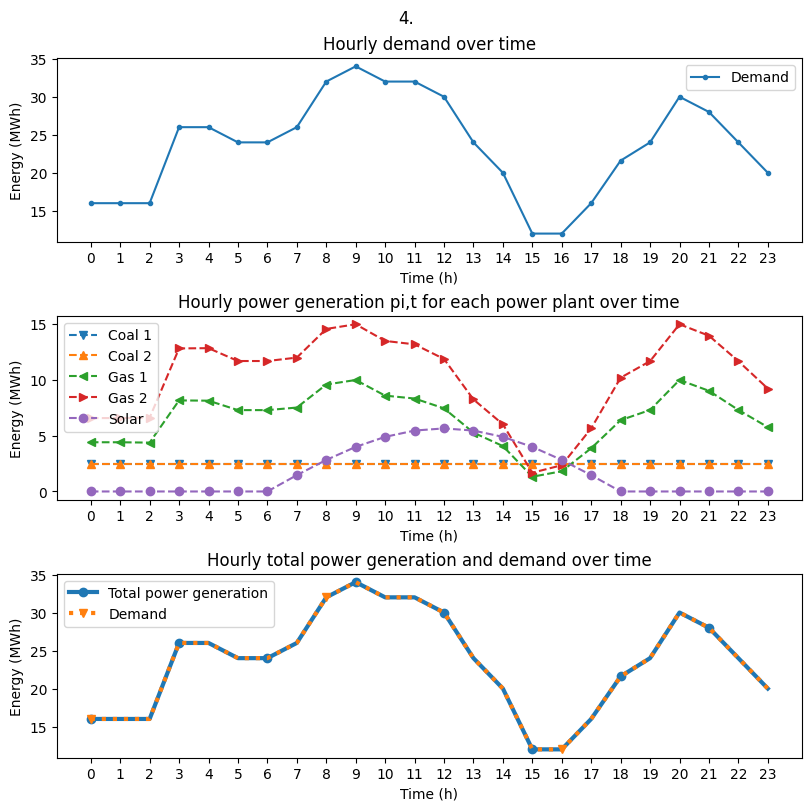

In [5]:
# figures
fig, ax = plt.subplots(3, layout='constrained', figsize=(8, 8))

markers = ['v', '^', '<', '>', 'o']

ax[0].plot(t, d, marker='.', label='Demand')
ax[0].set_title('Hourly demand over time')

for i in range(5):
    ax[1].plot(t, power[i], ls='--', marker=markers[i], label=power_plants[i])

ax[1].set_title('Hourly power generation pi,t for each power plant over time')

ax[2].plot(t,  np.sum(power, axis=0), ls='-', lw=3, marker='o', markevery=3, label='Total power generation')
ax[2].plot(t,  d, ls=':', lw=3, marker='v', markevery=8, label='Demand')
ax[2].set_title('Hourly total power generation and demand over time')

for i in range(3):
    ax[i].set_xlabel('Time (h)')
    ax[i].set_xticks(t)
    ax[i].set_ylabel('Energy (MWh)')
    ax[i].legend()

fig.suptitle('4.')
print('')

In [6]:
# LCOE
investment_costs = np.append(thermal_investment_costs.value, solar_investment_cost.value)
plant_NPV_fuel_costs = np.append(
    np.sum(NPV_fuel_costs.value, axis=1),
    0
)
NPV_optimal_dispatched_electricity = 365 * np.sum(power, axis=1) / (1+rate)

LCOE = (investment_costs+plant_NPV_fuel_costs) / NPV_optimal_dispatched_electricity

for i in range(5):
    print(f'LCOE of {power_plants[i]} is ${LCOE[i]:.2f}/MWh')

LCOE of Coal 1 is $524.03/MWh
LCOE of Coal 2 is $524.03/MWh
LCOE of Gas 1 is $496.78/MWh
LCOE of Gas 2 is $481.25/MWh
LCOE of Solar is $450.14/MWh


## Part I questions
1. The hourly dispatch shows that the hourly total power generation is equal to the power demand, which means that there is no curtailment. This is the optimal solution because it means that no escess money is spent on fueling thermal plants to produce more power than needed.
2. The driving factors that affect the installed capacities are:
3. The maximum capacity for the two gas plants were active constraints.
4. Solar has the least LCOE. The 2 gas plants have the next lowest LCOE. The coal plants have the highest LCOE. The optimization maximizes the cheaper LCOE solar first, but since solar cannot cover nighttime demand, the optimizer maximizes the next cheapest option which is gas.

# Part II

In [44]:
# define variables
Pmin_wind = 0
p = cp.Variable((n, T))
p_solar = cp.Variable(T)
p_wind = cp.Variable(T)
installed_thermal_capacity = cp.Variable(n)
installed_solar_capacity = cp.Variable()
installed_wind_capacity = cp.Variable()

# define constraints
constraints = [
    installed_thermal_capacity >= Pmin,
    installed_solar_capacity >= Pmin_solar,
    installed_wind_capacity >= Pmin_wind,
    installed_thermal_capacity <= Pmax,
    cp.sum(p, axis=0) + p_solar + p_wind >= d,
    p >= 0,
    p_solar >= 0,
    p_wind >= 0,
    p <= installed_thermal_capacity[:, np.newaxis],
    p_solar <= solar_cap_fact * installed_solar_capacity,
    p_wind <= wind_cap_fact * installed_wind_capacity,
    cp.abs(cp.diff(p, axis=1)) <= R[:, np.newaxis]
]

RPS = (cp.sum(p_solar)+cp.sum(p_wind)) / cp.sum(d)
RPS_constraints = np.append(0, np.arange(0.94, 1, 0.01))

# define costs
thermal_investment_costs = cp.multiply(
    [capital_cost_coal_plant]*2 + [capital_cost_gas_plant]*2,
    installed_thermal_capacity
)
solar_investment_cost = capital_cost_solar_plant_per_MW * installed_solar_capacity
wind_investment_cost = capital_cost_wind_plant_per_MW * installed_wind_capacity

fuel_costs = 365 * cp.multiply(p, fuel_cost_per_MWh_2018[:, np.newaxis])
NPV_fuel_costs = fuel_costs/(1 + rate)

# solve
total_NPV_costs = np.zeros(8)
installed_capacities = np.zeros((8, 6))
curtailments = np.zeros(8)

for i in range(8):
    problem = cp.Problem(cp.Minimize(
            cp.sum(NPV_fuel_costs) 
            + cp.sum(thermal_investment_costs) 
            + solar_investment_cost 
            + wind_investment_cost
        ), constraints + [RPS >= RPS_constraints[i]]
    )
    problem.solve()

    total_NPV_costs[i] = problem.value
    installed_capacities[i, :4] = installed_thermal_capacity.value
    installed_capacities[i, 4] = installed_solar_capacity.value
    installed_capacities[i, 5] = installed_wind_capacity.value
    curtailments[i] = np.sum(p.value) + np.sum(p_solar.value) + np.sum(p_wind.value) - np.sum(d)
    

    # print(i, f'RPS Lower bound:\t{RPS_constraints[i]}')
    # print(f'RPS\t{RPS.value}')
    # print(f'Total NP:\t{problem.value}')
    # print(f'Solar capacity:\t{installed_solar_capacity.value}')
    # print(f'Wind capacity:\t{installed_wind_capacity.value}')
    # print(f'Thermal capacity:\t{installed_thermal_capacity.value}\n')


In [ ]:
def make_bar_plot(axis, ):

Text(0.5, 1.0, 'Curtainment (for each scenario)')

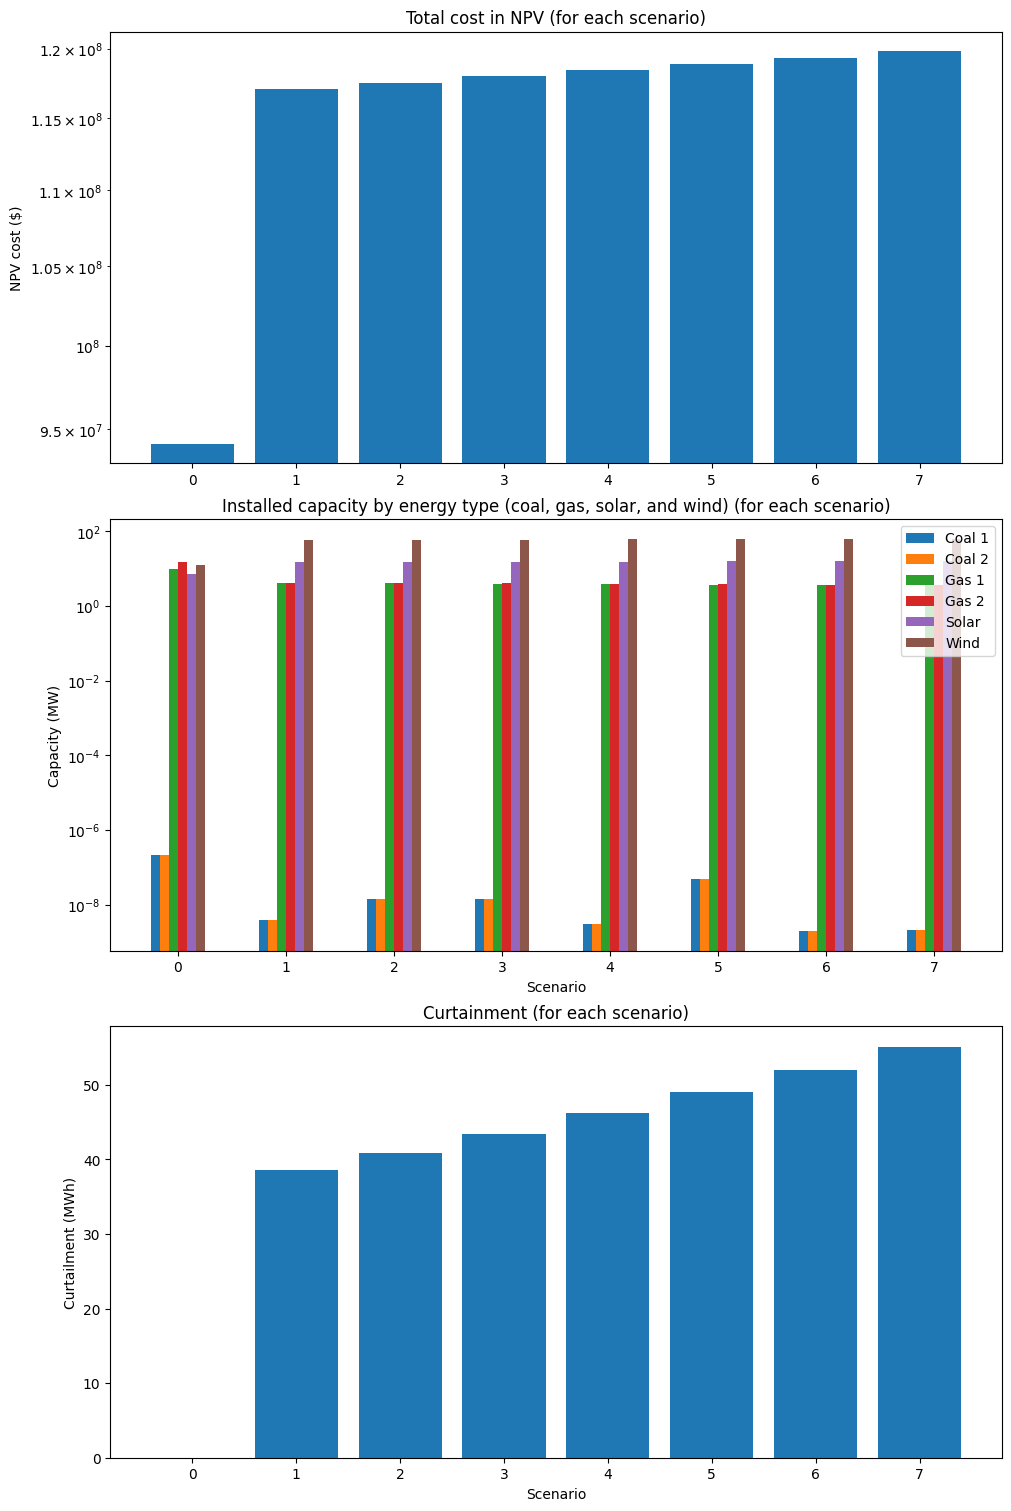

In [89]:
fig, ax = plt.subplots(3, figsize=(10, 15), layout='constrained')

ax[0].bar(range(8), total_NPV_costs)
ax[1].set_xlabel('Scenario')
ax[0].set_yscale('log')
ax[0].set_ylabel('NPV cost ($)')
ax[0].set_title('Total cost in NPV (for each scenario)')

offsets = (np.arange(-3, 3) + (1/2) ) / 12
power_plants = ['Coal 1', 'Coal 2', 'Gas 1', 'Gas 2', 'Solar', 'Wind']
for i in range(6):
    ax[1].bar(np.arange(8)+offsets[i], installed_capacities[:, i], width=(1/12), label=power_plants[i])

ax[1].set_xlabel('Scenario')
ax[1].set_yscale('log')
ax[1].set_ylabel('Capacity (MW)')
ax[1].set_title('Installed capacity by energy type (coal, gas, solar, and wind) (for each scenario)')
ax[1].legend()


ax[2].bar(range(8), curtailments)
ax[2].set_xlabel('Scenario')
ax[2].set_ylabel('Curtailment (MWh)')
ax[2].set_title('Curtainment (for each scenario)')



In [7]:
q = np.arange(n*T).reshape(n, T)
print(np.multiply(q, fuel_cost_per_MWh_2018[:, np.newaxis]))
# print(np.abs(np.diff(q, axis=1)) < R[:, np.newaxis])
# print(np.abs(np.diff(q, axis=1)).shape)
# print(np.sum(q, axis=0))
# print(np.transpose(q) @ (fuel_cost_per_MWh_2018))
# print(q < np.ones((n, 1)))
# r = np.arange(24).reshape(1,24)
# r < solar_cap_fact
# s = np.arange(4).reshape(4,1)
# print(s.T < Pmax)
# print((q < s).shape)
print(power.shape)

[[   0.     25.4    50.8    76.2   101.6   127.    152.4   177.8   203.2
   228.6   254.    279.4   304.8   330.2   355.6   381.    406.4   431.8
   457.2   482.6   508.    533.4   558.8   584.2 ]
 [ 609.6   635.    660.4   685.8   711.2   736.6   762.    787.4   812.8
   838.2   863.6   889.    914.4   939.8   965.2   990.6  1016.   1041.4
  1066.8  1092.2  1117.6  1143.   1168.4  1193.8 ]
 [1312.8  1340.15 1367.5  1394.85 1422.2  1449.55 1476.9  1504.25 1531.6
  1558.95 1586.3  1613.65 1641.   1668.35 1695.7  1723.05 1750.4  1777.75
  1805.1  1832.45 1859.8  1887.15 1914.5  1941.85]
 [1969.2  1996.55 2023.9  2051.25 2078.6  2105.95 2133.3  2160.65 2188.
  2215.35 2242.7  2270.05 2297.4  2324.75 2352.1  2379.45 2406.8  2434.15
  2461.5  2488.85 2516.2  2543.55 2570.9  2598.25]]
(5, 24)


In [70]:
 np.arange(-3, 3)/12 + 1/24

array([-0.20833333, -0.125     , -0.04166667,  0.04166667,  0.125     ,
        0.20833333])

In [57]:
0.5-0.33

0.16999999999999998